# Corrective RAG (CRAG)

Corrective RAG (CRAG)은 검색된 문서에 대한 자기 성찰/자체 평가를 포함하는 RAG 전략입니다.

여기 논문에서는 몇 가지 단계가 수행됩니다:

1. 적어도 하나의 문서가 관련성 임계값을 초과하면 생성 단계로 진행합니다.
2. 생성 전에 지식 정제를 수행합니다.
   - 이는 문서를 "지식 조각"으로 분할합니다.
   - 각 조각을 평가하고 관련 없는 것들을 필터링합니다.
3. 모든 문서가 관련성 임계값 미만이거나 평가자가 확신하지 못하는 경우, 프레임워크는 추가 데이터 소스를 찾습니다.
   - 웹 검색을 사용하여 검색을 보완합니다.

우리는 LangGraph를 사용하여 이러한 아이디어 중 일부를 처음부터 구현할 것입니다:

- 첫 번째 단계로 지식 정제 단계를 건너뛰겠습니다. 필요한 경우 나중에 노드로 추가할 수 있습니다.
- 관련 없는 문서가 있으면 웹 검색으로 검색을 보완하도록 하겠습니다.
- 웹 검색에는 Tavily Search를 사용할 것입니다.
- 웹 검색을 위해 쿼리를 최적화하기 위해 쿼리 재작성을 사용하겠습니다.

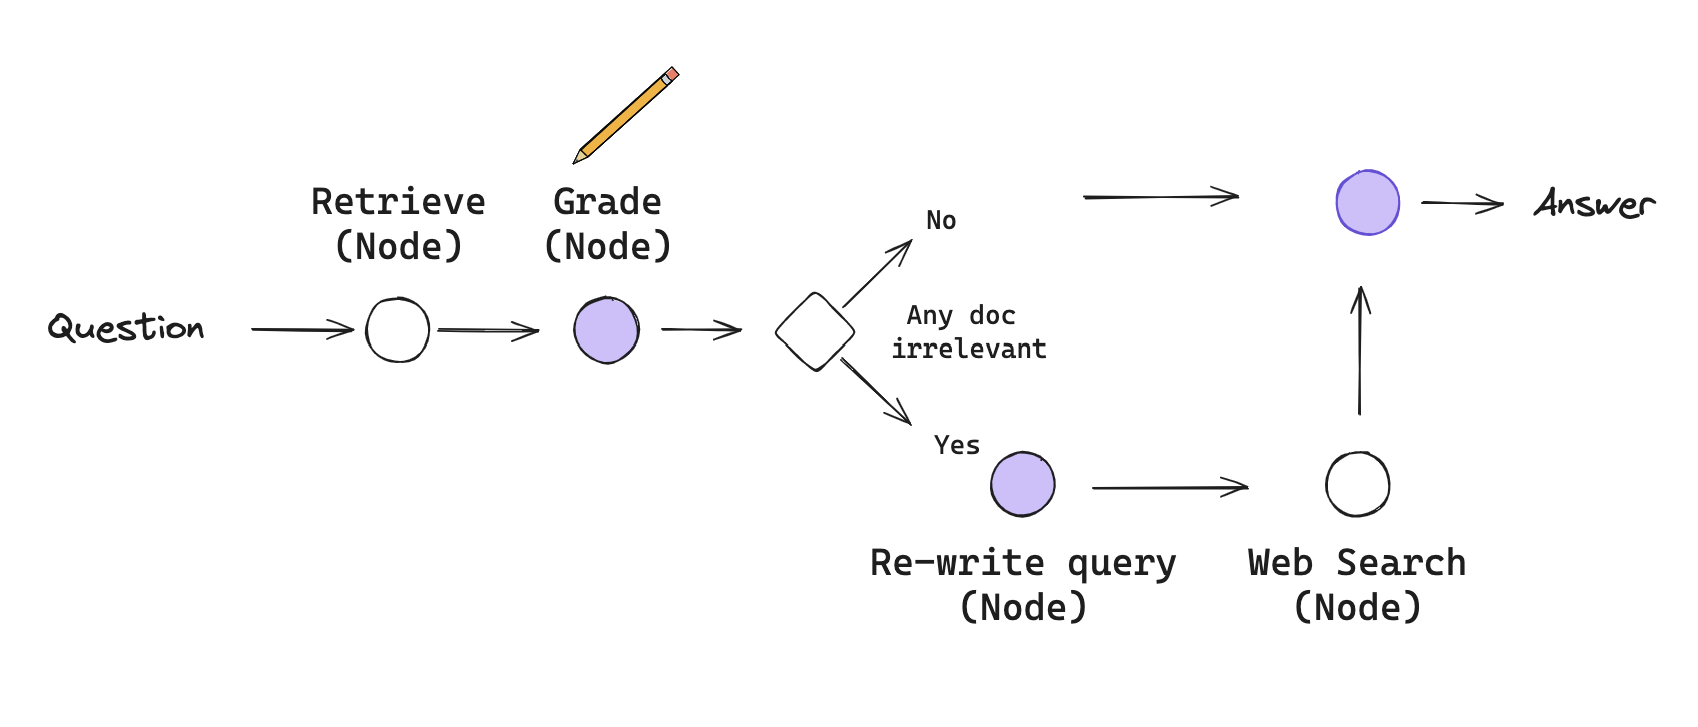

## Create Index

Let's index 3 blog posts.

In [1]:
# 필요한 라이브러리를 임포트합니다.
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# 분석할 블로그 포스트의 URL 목록을 정의합니다.
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# 각 URL에서 문서를 로드합니다.
# WebBaseLoader를 사용하여 각 URL의 내용을 가져옵니다.
docs = [WebBaseLoader(url).load() for url in urls]

# 중첩된 리스트를 평탄화하여 하나의 리스트로 만듭니다.
# 이렇게 하면 모든 문서가 하나의 리스트에 포함됩니다.
docs_list = [item for sublist in docs for item in sublist]

# 문서를 작은 청크로 분할하기 위해 RecursiveCharacterTextSplitter를 사용합니다.
# tiktoken 인코더를 사용하여 250 토큰 크기의 청크로 분할하며, 겹치는 부분은 없습니다.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# 위에서 정의한 splitter를 사용하여 문서를 분할합니다.
doc_splits = text_splitter.split_documents(docs_list)

# 분할된 문서를 벡터 데이터베이스에 추가합니다.
# Chroma를 사용하여 벡터 저장소를 생성하고, OpenAI의 임베딩 모델을 사용합니다.
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

# 생성된 벡터 데이터베이스에서 검색기(retriever)를 생성합니다.
# 이 검색기는 나중에 질문에 관련된 문서를 검색하는 데 사용됩니다.
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


## LLMs

>LangChain에서 Pydantic 사용

>이 노트북은 Pydantic v2의 BaseModel을 사용하며, 이는 langchain-core 0.3 이상이 필요합니다. langchain-core 0.3 미만을 사용하면 Pydantic v1과 v2 BaseModel이 혼합되어 오류가 발생할 수 있습니다.

### Retrieval Grader

In [2]:
# 필요한 라이브러리와 모듈을 가져옵니다.
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# 검색된 문서의 관련성을 평가하기 위한 데이터 모델을 정의합니다.
class GradeDocuments(BaseModel):
    """검색된 문서의 관련성을 이진 점수로 평가합니다."""

    binary_score: str = Field(
        description="문서가 질문과 관련이 있으면 'yes', 없으면 'no'"
    )

# OpenAI의 ChatGPT 모델을 사용하여 LLM을 초기화합니다.
llm = ChatOpenAI(model="gpt-4o", temperature=0)
# LLM에 구조화된 출력 기능을 추가합니다.
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 평가를 위한 시스템 프롬프트를 정의합니다.
system = """당신은 사용자 질문에 대한 검색된 문서의 관련성을 평가하는 평가자입니다. 
    문서에 질문과 관련된 키워드나 의미가 포함되어 있다면 관련성이 있다고 평가하세요. 
    문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 이진 점수를 매기세요."""

# 채팅 프롬프트 템플릿을 생성합니다.
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "검색된 문서: \n\n {document} \n\n 사용자 질문: {question}"),
    ]
)

# 검색 결과 평가 파이프라인을 구성합니다.
retrieval_grader = grade_prompt | structured_llm_grader

# 테스트를 위한 질문을 설정합니다.
question = "agent memory"
# 검색기를 사용하여 관련 문서를 검색합니다.
docs = retriever.invoke(question)
# 검색된 문서 중 두 번째 문서의 내용을 추출합니다.
doc_txt = docs[1].page_content
# 검색된 문서의 관련성을 평가하고 결과를 출력합니다.
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Generate

In [4]:
# 필요한 라이브러리와 모듈을 가져옵니다.
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# 프롬프트를 가져옵니다.
# 'rlm/rag-prompt'는 RAG(Retrieval-Augmented Generation) 작업에 최적화된 프롬프트입니다.
prompt = hub.pull("rlm/rag-prompt")

# LLM(Large Language Model)을 초기화합니다.
# 여기서는 OpenAI의 GPT-4o 모델을 사용하며, temperature를 0으로 설정하여 일관된 출력을 얻습니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 문서 포맷팅 함수를 정의합니다.
# 이 함수는 여러 문서의 내용을 하나의 문자열로 결합합니다.
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG 체인을 구성합니다.
# 프롬프트, LLM, 그리고 문자열 출력 파서를 연결하여 하나의 파이프라인을 만듭니다.
rag_chain = prompt | llm | StrOutputParser()

# RAG 체인을 실행합니다.
# 검색된 문서(context)와 질문을 입력으로 제공하고, 생성된 응답을 출력합니다.
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory in LLM-powered autonomous agents includes both short-term and long-term memory. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall extensive information over time, often using an external database. This memory system enables the agent to learn from past experiences and improve future actions.


### Question Re-writer

In [5]:
# LLM (대규모 언어 모델) 초기화
# GPT-4o 모델을 사용하며, temperature를 0으로 설정하여 일관된 출력을 얻습니다.
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# 프롬프트 설정
# 시스템 메시지: 질문 재작성기의 역할과 목적을 정의합니다.
system = """당신은 입력된 질문을 웹 검색에 최적화된 더 나은 버전으로 변환하는 질문 재작성기입니다. \n 
     입력을 보고 그 밑에 깔린 의미론적 의도나 의미를 추론하려고 노력하세요."""
# ChatPromptTemplate을 사용하여 대화형 프롬프트를 구성합니다.
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "여기 초기 질문이 있습니다: \n\n {question} \n 개선된 질문을 만들어주세요.",
        ),
    ]
)

# 질문 재작성 파이프라인 구성
# 프롬프트, LLM, 문자열 출력 파서를 연결하여 하나의 파이프라인을 만듭니다.
question_rewriter = re_write_prompt | llm | StrOutputParser()

# 질문 재작성 실행
# 미리 정의된 'question' 변수를 사용하여 질문을 재작성합니다.
question_rewriter.invoke({"question": question})

'에이전트 메모리란 무엇이며 어떻게 작동하나요?'

## Web Search Tool

In [6]:
### 웹 검색 도구 설정

# Tavily 검색 결과를 사용하기 위한 도구를 가져옵니다.
from langchain_community.tools.tavily_search import TavilySearchResults

# 웹 검색 도구를 초기화합니다.
# TavilySearchResults를 사용하여 검색 결과를 가져옵니다.
# 'k=3'은 상위 3개의 검색 결과만 반환하도록 설정합니다.
web_search_tool = TavilySearchResults(k=3)

# 이 웹 검색 도구는 이후 그래프에서 사용되어 
# 질문에 대한 추가 정보를 온라인에서 검색하는 데 활용됩니다.

## Create Graph

이제 CRAG를 사용할 그래프를 만들어 봅시다

### State

In [10]:
from typing import List
from typing_extensions import TypedDict

# GraphState 클래스 정의
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 클래스입니다.

    속성:
        question (str): 사용자가 입력한 질문
        generation (str): 언어 모델(LLM)이 생성한 답변
        web_search (str): 웹 검색 수행 여부를 나타내는 문자열
        documents (List[str]): 검색된 문서들의 리스트

    이 클래스는 TypedDict를 상속받아 각 속성의 타입을 명시적으로 정의합니다.
    이를 통해 코드의 가독성과 타입 안정성을 높일 수 있습니다.
    """

    question: str  # 사용자의 질문을 저장하는 문자열
    generation: str  # LLM이 생성한 답변을 저장하는 문자열
    web_search: str  # 웹 검색 수행 여부를 나타내는 문자열 (예: "yes" 또는 "no")
    documents: List[str]  # 검색된 문서들을 저장하는 문자열 리스트

### Node

In [11]:
from langchain.schema import Document


def retrieve(state):
    """
    문서를 검색하는 함수입니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 검색된 문서가 추가된 새로운 상태
    """
    print("---검색 시작---")
    question = state["question"]

    # 문서 검색 수행
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    답변을 생성하는 함수입니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): LLM이 생성한 답변이 추가된 새로운 상태
    """
    print("---답변 생성 시작---")
    question = state["question"]
    documents = state["documents"]

    # RAG를 사용한 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 평가하는 함수입니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 관련성이 있는 문서만 필터링된 새로운 상태
    """

    print("---문서의 질문 관련성 확인 시작---")
    question = state["question"]
    documents = state["documents"]

    # 각 문서 평가
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---평가 결과: 문서 관련성 있음---")
            filtered_docs.append(d)
        else:
            print("---평가 결과: 문서 관련성 없음---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    더 나은 질문을 만들기 위해 쿼리를 변환하는 함수입니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 다시 작성된 질문으로 업데이트된 상태
    """

    print("---쿼리 변환 시작---")
    question = state["question"]
    documents = state["documents"]

    # 질문 다시 작성
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    다시 작성된 질문을 기반으로 웹 검색을 수행하는 함수입니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 웹 검색 결과가 추가된 새로운 상태
    """

    print("---웹 검색 시작---")
    question = state["question"]
    documents = state["documents"]

    # 웹 검색 수행
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}




### Edge

In [12]:
def decide_to_generate(state):
    """
    답변을 생성할지 또는 질문을 다시 생성할지 결정하는 함수입니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        str: 다음에 호출할 노드를 결정하는 이진 결정
    """

    print("---평가된 문서 분석 시작---")
    web_search = state["web_search"]

    if web_search == "Yes":
        # 모든 문서가 관련성이 없다고 판단됨
        # 새로운 쿼리를 생성할 예정
        print(
            "---결정: 모든 문서가 질문과 관련이 없습니다. 쿼리를 변환합니다---"
        )
        return "transform_query"
    else:
        # 관련 있는 문서가 있으므로 답변 생성
        print("---결정: 답변 생성---")
        return "generate"

### Compile Graph


그림에서 설명한 흐름을 따릅니다.

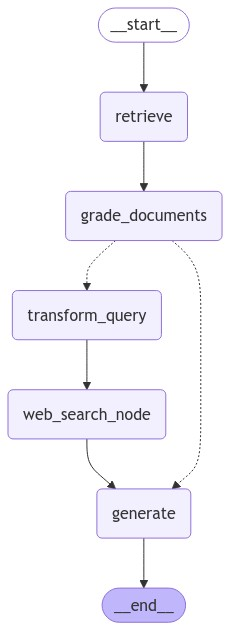

In [13]:
# langgraph 라이브러리에서 필요한 클래스들을 가져옵니다.
from langgraph.graph import END, StateGraph, START

# GraphState를 기반으로 새로운 워크플로우 그래프를 생성합니다.
workflow = StateGraph(GraphState)

# 그래프의 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve)  # 문서 검색 노드
workflow.add_node("grade_documents", grade_documents)  # 문서 평가 노드
workflow.add_node("generate", generate)  # 답변 생성 노드
workflow.add_node("transform_query", transform_query)  # 쿼리 변환 노드
workflow.add_node("web_search_node", web_search)  # 웹 검색 노드

# 그래프의 엣지(연결)를 구성합니다.
workflow.add_edge(START, "retrieve")  # 시작점에서 문서 검색으로
workflow.add_edge("retrieve", "grade_documents")  # 문서 검색에서 문서 평가로

# 조건부 엣지를 추가합니다. decide_to_generate 함수의 결과에 따라 다음 노드가 결정됩니다.
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",  # 쿼리 변환이 필요한 경우
        "generate": "generate",  # 바로 답변 생성이 가능한 경우
    },
)

workflow.add_edge("transform_query", "web_search_node")  # 쿼리 변환 후 웹 검색으로
workflow.add_edge("web_search_node", "generate")  # 웹 검색 후 답변 생성으로
workflow.add_edge("generate", END)  # 답변 생성 후 종료

# 워크플로우를 컴파일하여 실행 가능한 앱으로 만듭니다.
app = workflow.compile()

# 그래프를 시각화하기 위한 라이브러리를 가져옵니다.
from IPython.display import Image, display
 
# 컴파일된 앱의 그래프를 Mermaid 형식의 PNG 이미지로 그리고 표시합니다.
display(Image(app.get_graph().draw_mermaid_png()))

## Use the graph

In [14]:
from pprint import pprint

# 그래프 실행을 위한 입력 설정
inputs = {"question": "에이전트 메모리의 종류는 무엇인가요?"}

# 그래프 실행 및 결과 출력
for output in app.stream(inputs):
    for key, value in output.items():
        # 현재 실행 중인 노드 이름 출력
        pprint(f"현재 실행 중인 노드: '{key}':")
        
        # 선택사항: 각 노드에서의 전체 상태 출력
        # 필요한 경우 아래 주석을 해제하여 사용할 수 있습니다.
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    
    # 노드 간 구분선 출력
    pprint("\n---\n")

# 최종 생성된 답변 출력
pprint("최종 생성된 답변:")
pprint(value["generation"])

---검색 시작---
"현재 실행 중인 노드: 'retrieve':"
'\n---\n'
---문서의 질문 관련성 확인 시작---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가된 문서 분석 시작---
---결정: 답변 생성---
"현재 실행 중인 노드: 'grade_documents':"
'\n---\n'
---답변 생성 시작---
"현재 실행 중인 노드: 'generate':"
'\n---\n'
'최종 생성된 답변:'
('에이전트 메모리의 종류는 감각 기억, 단기 기억, 그리고 장기 기억입니다. 감각 기억은 시각, 청각 등 감각 정보를 짧게 유지하며, 단기 '
 '기억은 현재 인지하고 있는 정보를 저장합니다. 장기 기억은 사실과 사건을 오랜 기간 동안 저장할 수 있습니다.')


In [15]:
# 그래프 실행을 위한 입력 설정
inputs = {"question": "베어스가 NFL 드래프트에서 첫 번째로 누구를 선발할 것인가?"}

# 그래프 실행 및 결과 출력
for output in app.stream(inputs):
    for key, value in output.items():
        # 현재 실행 중인 노드 이름 출력
        pprint(f"현재 실행 중인 노드: '{key}':")
        
        # 선택사항: 각 노드에서의 전체 상태 출력
        # 필요한 경우 아래 주석을 해제하여 사용할 수 있습니다.
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    
    # 노드 간 구분선 출력
    pprint("\n---\n")

# 최종 생성된 답변 출력
pprint("최종 생성된 답변:")
pprint(value["generation"])

---검색 시작---
"현재 실행 중인 노드: 'retrieve':"
'\n---\n'
---문서의 질문 관련성 확인 시작---
---평가 결과: 문서 관련성 없음---
---평가 결과: 문서 관련성 없음---
---평가 결과: 문서 관련성 없음---
---평가 결과: 문서 관련성 없음---
---평가된 문서 분석 시작---
---결정: 모든 문서가 질문과 관련이 없습니다. 쿼리를 변환합니다---
"현재 실행 중인 노드: 'grade_documents':"
'\n---\n'
---쿼리 변환 시작---
"현재 실행 중인 노드: 'transform_query':"
'\n---\n'
---웹 검색 시작---
"현재 실행 중인 노드: 'web_search_node':"
'\n---\n'
---답변 생성 시작---
"현재 실행 중인 노드: 'generate':"
'\n---\n'
'최종 생성된 답변:'
'2023년 NFL 드래프트에서 시카고 베어스가 첫 번째로 지명한 선수는 테네시대 출신 라인맨 다넬 라이트입니다.'
